# Variational Autoencoder (VAE)

In this homework I trained an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset [http://vis-www.cs.umass.edu/lfw/](http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)


## Prepare the data

In [65]:
ls

lfw_attributes.txt  lfw-deepfunneled/  sample_data/


In [0]:
# import comet_ml in the top of your file
# from comet_ml import Experiment
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [0]:
import numpy as np
import os
from scipy.misc import imread,imresize
import pandas as pd

def fetch_lfw_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      raw_images_name = "lfw",
                      use_raw=False,
                      dx=80,dy=80,
                      dimx=45,dimy=45
    ):#sad smile

    #download if not exists
    if (not use_raw) and not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)
    
    if use_raw and not os.path.exists(raw_images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(raw_images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s"%attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])
    df_attrs.imagenum = df_attrs.imagenum.astype(np.int64)


    #read photos
    dirname = raw_images_name if use_raw else images_name
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(dirname):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)

    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    #image preprocessing
    all_photos =df['photo_path'].apply(imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: imresize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs
    

In [4]:
# The following code fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind

    
data, attrs = fetch_lfw_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


In [5]:
data.shape

(13143, 45, 45, 3)

In [6]:
X_train = data[:10000].reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 6075)
(3143, 6075)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [0]:
X_train = np.float32(X_train)
X_train = X_train/255
X_val = np.float32(X_val)
X_val = X_val/255

In [0]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

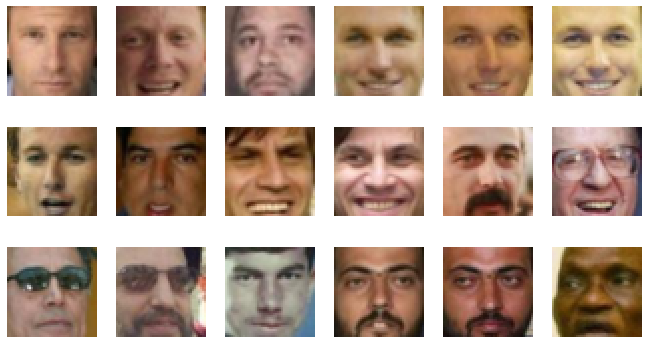

In [9]:
plot_gallery(X_train, image_h, image_w)

In [0]:
def generate_minibatches(X_train, n_batch):
    indices = np.arange(len(X_train))
    np.random.shuffle(indices)
    for start_indx in range(0, len(X_train) - n_batch + 1, n_batch):
        batch_indices = indices[start_indx:start_indx+n_batch]
        yield batch_indices

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is splitting bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler**, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

In [0]:
def KL_divergence(mu, logsigma):
    kl = -0.5*tf.reduce_sum(1 + logsigma - mu**2 - tf.exp(logsigma))
    return kl

  

In [0]:

dimZ = 100

tf.reset_default_graph();
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)
# create a placeholder for the input image
batch_size = tf.placeholder(tf.int32)
X = tf.placeholder(tf.float32, shape=[None, 6075])
### Encoder
fc_layer1 = tf.layers.dense(X, 1000, activation=tf.nn.relu, kernel_initializer=tf.glorot_uniform_initializer())
fc_layer2 = tf.layers.dense(fc_layer1, 500, activation=tf.nn.relu, kernel_initializer=tf.glorot_uniform_initializer())

z_mu = tf.layers.dense(fc_layer2, dimZ, activation=tf.nn.relu, kernel_initializer=tf.glorot_uniform_initializer())
z_logsigma = tf.layers.dense(fc_layer1, dimZ, activation=tf.nn.relu, kernel_initializer=tf.glorot_uniform_initializer())
Z = z_mu + tf.exp(0.5*z_logsigma)*tf.random_normal([4, 100])
### Decoder 
fc_layer3 = tf.layers.dense(Z, 500, activation=tf.nn.relu, kernel_initializer=tf.glorot_uniform_initializer())

fc_layer4 = tf.layers.dense(fc_layer3, 1000, activation=tf.nn.relu, kernel_initializer=tf.glorot_uniform_initializer())
reconstr = tf.layers.dense(fc_layer4, 6075, activation=tf.nn.sigmoid, kernel_initializer=tf.glorot_uniform_initializer())

cross_entropy = -tf.reduce_mean(X * tf.log(reconstr) + (1 - X)*tf.log(1 - reconstr), 
        axis=1)
kl = KL_divergence(z_mu, z_logsigma)
loss = tf.reduce_mean(kl + cross_entropy)
train_step = tf.train.AdamOptimizer(0.0001).minimize(loss)



$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$


$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_I-x)^2}{2\sigma_i^2}} \Big)=...$$



In [84]:

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss_train_epoch = {}
    for epoch in range(0, 10):
        loss_train = 0
        for bacth_indices in generate_minibatches(X_train, 4):
            X_train_minibatch = X_train[bacth_indices]
            [loss_val, rec_img_batch] = sess.run([loss, reconstr], feed_dict={batch_size: 4, X:X_train_minibatch})
            train_step.run(feed_dict={X: X_train_minibatch})
            loss_train += loss_val
        loss_train_epoch[epoch] = loss_train
        print("epoch {}, training loss {}".format(epoch, loss_train_epoch[epoch]/2500))
    output = sess.run([reconstr], feed_dict={Z:z})
    print("validation loss {}".format(loss_val))

epoch 0, training loss 0.6948999472379684
epoch 1, training loss 0.6590963907003403
epoch 2, training loss 0.6582249598741532
epoch 3, training loss 0.6581868307352066
epoch 4, training loss 0.6581454505205154
epoch 5, training loss 0.6580942550897598
epoch 6, training loss 0.6580357439994812
epoch 7, training loss 0.6580209002971649
epoch 8, training loss 0.6580110033035278
epoch 9, training loss 0.6579816474676132
validation loss 0.6415808200836182


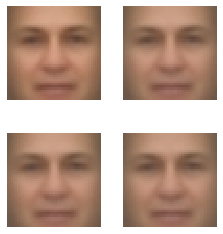

In [85]:
plot_gallery(np.array(output).reshape([4, 6075]), image_h, image_w, n_row=2, n_col=2)